In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
# from sklearn.learning_curve import validation_curve
# from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error
from sklearn.cluster import KMeans
import statsmodels.api as sm
import math
from scipy import stats
from scipy.stats import boxcox
from scipy.special import boxcox1p


/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [26]:
from IPython.display import HTML
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
*The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


In [3]:
df = pd.read_csv('nfl_betting_df.csv', index_col = 0)

df['exp_win_difference'] = df.home_exp_win_pct- df.away_exp_win_pct
df['schedule_date']=df['schedule_date'].apply(pd.to_datetime)
df = df[df.schedule_season > 1978]

df['total_ppg'] = (df.h_ppg + df.a_ppg)
df['total_points_against'] = (df.h_papg + df.a_papg)
df['last_four_difference'] = (df.home_win_pct_last_4 - df.away_win_pct_last_4)

df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']]=df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']].fillna(value=np.round(df.mean(),3))
df[['over_under_line']]=df[['over_under_line']].fillna(value=(np.round(df.mean()*2)/2))

df['over_under_result'] = np.where(df['over_under_result']=='under', 0, df.over_under_result)
df['over_under_result'] = np.where(df['over_under_result']=='over', 1, df.over_under_result)
df['over_under_result'] = np.where(df['over_under_result']=='push', 2, df.over_under_result)

df['dome'] = np.where(df['weather_detail']=='DOME', 1, 0)

df = df.fillna(value = 0)

df.index = range(0, len(df))

reg_df = df[(df.schedule_week > 1) & (df.schedule_week < 19) & (df.schedule_season>2001)]
week5_df = df[(df.schedule_week > 4) & (df.schedule_week < 17) & (df.schedule_season>2001)]

In [4]:
def untransform(arr, lambda_):
    result = np.exp(np.log(lambda_ * arr + 1) / lambda_)
    return result

In [5]:
cluster_df = pd.read_csv('cluster_df.csv',index_col=0)

good_o_good_d = cluster_df[cluster_df.cluster==2]
bad_o_bad_d = cluster_df[cluster_df.cluster==0]
bad_o_good_d = cluster_df[cluster_df.cluster==1]
good_o_bad_d = cluster_df[cluster_df.cluster==3]
#cluster_df

In [6]:
def past_predictions(df):
    y_preds = []
    for index, row in df.iterrows():

        yt,max_lambda =boxcox(week5_df.over_under_line)
        xt1,x1_lam=boxcox(week5_df.total_points_against)
        xt2,x2_lam=boxcox(week5_df.total_ppg)
        xt3,x3_lam=boxcox(week5_df.weather_temperature+1)
        xt4,x4_lam=boxcox(week5_df.weather_wind_mph+1)
        xt7,xlam7=boxcox(week5_df.schedule_season)

        papg = boxcox1p(row.total_points_against,x1_lam)
        ppg = boxcox1p(row.total_ppg,x2_lam)
        temp = boxcox1p(row.weather_temperature,x3_lam)
        wind = boxcox1p(row.weather_wind_mph,x4_lam)
        dome = row.dome
        season = boxcox1p(row.schedule_season,xlam7)
        
        y = -2.575851e+06 + 6.509747e-02*papg +3.615986e-01*ppg + 1.505438e-04*temp + -2.959061e-02*wind + 1.402209e-01*dome +4.085226e+06*season 
        y_pred = np.round(untransform(y,max_lambda)*2)/2
        y_preds.append(y_pred)
            
    return y_preds

In [7]:
past_preds = past_predictions(week5_df)
#past_preds

In [8]:
atl_phi = {'home_id':'PHI','away_id':'ATL', 'over_under':47.5,
          'TPAPG':20.33+19.27,'TPPG':22.07+30.47,'temp':83,'wind':7,'humidity':66.552,'dome':0,'date':'9/6/18','time':'night'}
pit_cle = {'home_id':'CLE','away_id':'PIT', 'over_under':48,
          'TPAPG':18.93+25.47,'TPPG':25.2+14,'temp':67,'wind':7,'humidity':66.552,'dome':0,'date':'9/9/18','time':'1pm'}
sf_min = {'home_id':'MIN','away_id':'SF', 'over_under':47.5,
          'TPAPG':24.67+16.16,'TPPG':19.8+23.93,'temp':72,'wind':0,'humidity':66.552,'dome':1,'date':'9/9/18','time':'1pm'}
cin_ind = {'home_id':'IND', 'away_id':'CIN', 'over_under':47.5,
          'TPAPG':26.07+21.47,'TPPG':16+17.27,'temp':72,'wind':0,'humidity':66.552,'dome':1,'date':'9/9/18','time':'1pm'}
buf_bal = {'home_id':'BAL', 'away_id':'BUF', 'over_under':42,
          'TPAPG':18.13+22.87,'TPPG':18.67+24.53,'temp':73.5,'wind':3.5,'humidity':66.552,'dome':0,'date':'9/9/18','time':'1pm'}
jax_nyg = {'home_id':'NYG', 'away_id':'JAX', 'over_under':44.5,
          'TPAPG':25.2+16.87,'TPPG':15.2+27.13,'temp':72,'wind':7,'humidity':66.552,'dome':0,'date':'9/9/18','time':'1pm'}
tb_no = {'home_id':'NO', 'away_id':'TB', 'over_under':52.5,
          'TPAPG':23.87+19.67,'TPPG':20.27+28.27,'temp':72,'wind':0,'humidity':66.552,'dome':1,'date':'9/9/18','time':'1pm'}
hou_ne = {'home_id':'NE', 'away_id':'HOU', 'over_under':51,
          'TPAPG':19.33+27.6,'TPPG':28.8+21.67,'temp':71.67,'wind':6.67,'humidity':66.552,'dome':0,'date':'9/9/18','time':'1pm'}
ten_mia = {'home_id':'MIA', 'away_id':'TEN', 'over_under':47,
          'TPAPG':24.73+23.07,'TPPG':17.67+21.27,'temp':85,'wind':9,'humidity':66.552,'dome':0,'date':'9/9/18','time':'1pm'}
kc_lac = {'home_id':'LAC', 'away_id':'KC', 'over_under':48.5,
          'TPAPG':17.47+21,'TPPG':25.87+21.67,'temp':79,'wind':6.33,'humidity':66.552,'dome':0,'date':'9/9/18','time':'4pm'}
sea_den = {'home_id':'DEN', 'away_id':'SEA', 'over_under':42,
          'TPAPG':20.33+23.67,'TPPG':17.67+22.8,'temp':74.67,'wind':5.67,'humidity':66.552,'dome':0,'date':'9/9/18','time':'4pm'}
dal_car = {'home_id':'CAR', 'away_id':'DAL', 'over_under':42,
          'TPAPG':22.13+20.33,'TPPG':23.2+23.53,'temp':82,'wind':5,'humidity':66.552,'dome':0,'date':'9/9/18','time':'4pm'}
was_ari = {'home_id':'ARI', 'away_id':'WAS', 'over_under':45,
          'TPAPG':24.67+22.47,'TPPG':22.13+17.93,'temp':72,'wind':0,'humidity':66.552,'dome':1,'date':'9/9/18','time':'4pm'}
chi_gb = {'home_id':'GB', 'away_id':'CHI', 'over_under':48.5,
          'TPAPG':23.27+19.8,'TPPG':20.6+16.93,'temp':71,'wind':8.33,'humidity':66.552,'dome':0,'date':'9/9/18','time':'night'}
nyj_det = {'home_id':'DET', 'away_id':'NYJ', 'over_under':48.5,
          'TPAPG':24.33+23.73,'TPPG':25+19.47,'temp':72,'wind':0,'humidity':66.552,'dome':1,'date':'9/10/18','time':'night'}
lar_oak = {'home_id':'OAK', 'away_id':'LAR', 'over_under':49.5,
          'TPAPG':19.67+22.87,'TPPG':31+19.4,'temp':69,'wind':6,'humidity':66.552,'dome':0,'date':'9/10/18','time':'night'}

week1_games = [atl_phi,pit_cle,sf_min,cin_ind,buf_bal,jax_nyg,tb_no,hou_ne,ten_mia,kc_lac,sea_den,dal_car,was_ari,chi_gb,nyj_det,lar_oak]
w1 = pd.DataFrame(week1_games)
w1 = w1.drop(columns=['humidity','time'])

In [9]:
w1['good_o_good_d']= np.where((w1.TPPG>=48) & (w1.TPAPG<=48),1,0)
w1['good_o_bad_d']= np.where((w1.TPPG>=48) & (w1.TPAPG>=48),1,0)
w1['bad_o_good_d']= np.where((w1.TPPG<=48) & (w1.TPAPG<=48),1,0)
w1['bad_o_bad_d']= np.where((w1.TPPG<=48) & (w1.TPAPG>=48),1,0)

In [10]:
o_u_pivot = week5_df.pivot_table(index='over_under_line', columns='over_under_result',
                    aggfunc={'over_under_result':len}, fill_value = 0)
o_u_pivot['row_total'] = 0
for index, row in o_u_pivot.iterrows():
    row.row_total = sum(row)
ou_covered = o_u_pivot.over_under_result[1]
ou_no_cover = o_u_pivot.over_under_result[0]
ou_push = o_u_pivot.over_under_result[2]
lines = sorted(set(week5_df.over_under_line))
x_lines = np.array([spread for spread in lines])
y_over = [ou_covered[value]/o_u_pivot['row_total'][value] for value in x_lines]
y_under = [ou_no_cover[value]/o_u_pivot['row_total'][value] for value in x_lines]
y_neither = [ou_push[value]/o_u_pivot['row_total'][value] for value in x_lines]
prob_over = list(zip(x_lines,y_over))
prob_under = list(zip(x_lines,y_under))
prob_push = list(zip(x_lines,y_neither))

In [11]:
preds_df = week5_df.drop(columns=['weather_detail', 'weather_temperature', 'weather_wind_mph',
       'weather_humidity', 'score_difference', 'home_id', 'away_id',
       'home_favorite', 'favorite_covered', 'winning_team', 'losing_team',
       'home_wins', 'home_losses', 'home_ties', 'away_wins', 'away_losses',
       'away_ties', 'home_points_for', 'home_points_against',
       'away_points_for', 'away_points_against', 'h_games', 'a_games',
       'home_win_pct', 'away_win_pct', 'win_pct_diff', 'h_ppg', 'h_papg',
       'a_ppg', 'a_papg', 'home_pt_diff_pg', 'away_pt_diff_pg', 'pt_diff_pg',
       'home_exp_win_pct', 'away_exp_win_pct', 'home_win_pct_last_4',
       'away_win_pct_last_4', 'exp_win_difference', 'total_ppg',
       'total_points_against', 'last_four_difference', 'dome','team_favorite_id','spread_favorite'])
preds_df['over_under_pred'] = past_preds
preds_df['pred-actual'] = preds_df.over_under_pred- preds_df.over_under_line

preds_df['good_pred']= np.where((preds_df.over_under_pred>preds_df.over_under_line) & 
                                (preds_df.point_total>preds_df.over_under_line),1,0)
preds_df['good_pred']= np.where((preds_df.over_under_pred<preds_df.over_under_line) & 
                                (preds_df.point_total<preds_df.over_under_line),1,preds_df.good_pred)
preds_df['good_pred']= np.where((preds_df.over_under_pred==preds_df.over_under_line),1,preds_df.good_pred)
preds_df['good_pred']= np.where((preds_df.point_total==preds_df.over_under_line),1,preds_df.good_pred)

preds_df['new_ou_result']=np.where(preds_df.over_under_pred<preds_df.point_total,1,0)
preds_df['new_ou_result']=np.where(preds_df.over_under_pred==preds_df.point_total,2,preds_df.new_ou_result)
#preds_df[preds_df.over_under_result==2]

# Week 1 Predictions

In [12]:
def week_one_predictions(df):
    y_preds = []
    for index, row in df.iterrows():

        yt,max_lambda =boxcox(week5_df.over_under_line)
        xt1,x1_lam=boxcox(week5_df.total_points_against)
        xt2,x2_lam=boxcox(week5_df.total_ppg)
        xt3,x3_lam=boxcox(week5_df.weather_temperature+1)
        xt4,x4_lam=boxcox(week5_df.weather_wind_mph+1)
        xt7,xlam7=boxcox(week5_df.schedule_season)

        papg = boxcox1p(row.TPAPG,x1_lam)
        ppg = boxcox1p(row.TPPG,x2_lam)
        temp = boxcox1p(row.temp,x3_lam)
        wind = boxcox1p(row.wind,x4_lam)
        dome = row.dome
        season = boxcox1p(2018,xlam7)
        
        y = -2.575851e+06 + 6.509747e-02*papg +3.615986e-01*ppg + 1.505438e-04*temp + -2.959061e-02*wind + 1.402209e-01*dome +4.085226e+06*season 
        y_pred = np.round(untransform(y,max_lambda)*2)/2
        y_preds.append(y_pred)
            
    return y_preds

In [13]:
reg_w1 = w1
reg_w1_preds = week_one_predictions(reg_w1)
reg_w1['prediction'] = reg_w1_preds
reg_w1['pred-actual'] = reg_w1.prediction- reg_w1.over_under
#reg_w1

,TPAPG,TPPG,away_id,date,dome,home_id,over_under,temp,wind,good_o_good_d,good_o_bad_d,bad_o_good_d,bad_o_bad_d,prediction,pred-actual
0,39.60,52.54,ATL,9/6/18,0,PHI,47.5,83.00,7.00,1,0,0,0,47.0,-0.5
1,44.40,39.20,PIT,9/9/18,0,CLE,48.0,67.00,7.00,0,0,1,0,42.0,-6.0
2,40.83,43.73,SF,9/9/18,1,MIN,47.5,72.00,0.00,0,0,1,0,45.0,-2.5
3,47.54,33.27,CIN,9/9/18,1,IND,47.5,72.00,0.00,0,0,1,0,42.0,-5.5
4,41.00,43.20,BUF,9/9/18,0,BAL,42.0,73.50,3.50,0,0,1,0,43.5,1.5
5,42.07,42.33,JAX,9/9/18,0,NYG,44.5,72.00,7.00,0,0,1,0,43.0,-1.5
6,43.54,48.54,TB,9/9/18,1,NO,52.5,72.00,0.00,1,0,0,0,48.0,-4.5
7,46.93,50.47,HOU,9/9/18,0,NE,51.0,71.67,6.67,1,0,0,0,48.0,-3.0
8,47.80,38.94,TEN,9/9/18,0,MIA,47.0,85.00,9.00,0,0,1,0,43.5,-3.5
9,38.47,47.54,KC,9/9/18,0,LAC,48.5,79.00,6.33,0,0,1,0,44.5,-4.0


In [14]:
def bayes(line, our_prediction):
    over = [prob[1] for prob in prob_over if prob[0] == line][0]
    under = [prob[1] for prob in prob_under if prob[0] == line][0]
    push = [prob[1] for prob in prob_push if prob[0] == line][0]
    
    pred_o_given_o = len(preds_df[(preds_df.over_under_result==1) & (preds_df.over_under_line==line) & (preds_df.over_under_pred>preds_df.over_under_line)])/len(preds_df[(preds_df.over_under_result==1) & (preds_df.over_under_line==line)])
    pred_p_given_o = len(preds_df[(preds_df.over_under_result==1) & (preds_df.over_under_line==line) & (preds_df.over_under_pred==preds_df.over_under_line)])/len(preds_df[(preds_df.over_under_result==1) & (preds_df.over_under_line==line)])
    pred_u_given_o = len(preds_df[(preds_df.over_under_result==1) & (preds_df.over_under_line==line) & (preds_df.over_under_pred<preds_df.over_under_line)])/len(preds_df[(preds_df.over_under_result==1) & (preds_df.over_under_line==line)])

    pred_o_given_p = len(preds_df[(preds_df.over_under_result==2) & (preds_df.over_under_line==line) & (preds_df.over_under_pred>preds_df.over_under_line)])/(len(preds_df[(preds_df.over_under_result==2) & (preds_df.over_under_line==line)])+1)
    pred_p_given_p = len(preds_df[(preds_df.over_under_result==2) & (preds_df.over_under_line==line) & (preds_df.over_under_pred==preds_df.over_under_line)])/(len(preds_df[(preds_df.over_under_result==2) & (preds_df.over_under_line==line)])+1)
    pred_u_given_p = len(preds_df[(preds_df.over_under_result==2) & (preds_df.over_under_line==line) & (preds_df.over_under_pred<preds_df.over_under_line)])/(len(preds_df[(preds_df.over_under_result==2) & (preds_df.over_under_line==line)])+1)

    pred_o_given_u = len(preds_df[(preds_df.over_under_result==0) & (preds_df.over_under_line==line) & (preds_df.over_under_pred>preds_df.over_under_line)])/len(preds_df[(preds_df.over_under_result==0) & (preds_df.over_under_line==line)])
    pred_p_given_u = len(preds_df[(preds_df.over_under_result==0) & (preds_df.over_under_line==line) & (preds_df.over_under_pred==preds_df.over_under_line)])/len(preds_df[(preds_df.over_under_result==0) & (preds_df.over_under_line==line)])
    pred_u_given_u = len(preds_df[(preds_df.over_under_result==0) & (preds_df.over_under_line==line) & (preds_df.over_under_pred<preds_df.over_under_line)])/len(preds_df[(preds_df.over_under_result==0) & (preds_df.over_under_line==line)])

    if our_prediction < line:
        joint1 = pred_o_given_u * under
        joint2 = pred_p_given_u * under
        joint3 = pred_u_given_u * under
        normalizer = joint1 + joint2 + joint3
        return (joint3/normalizer)
    elif our_prediction > line:
        joint1 = pred_o_given_o * over
        joint2 = pred_p_given_o * over
        joint3 = pred_u_given_o * over
        normalizer = joint1 + joint2 + joint3
        return (joint1/normalizer)
    elif our_prediction == line:
        joint1 = pred_o_given_p * push
        joint2 = pred_p_given_p * push
        joint3 = pred_u_given_p * push
        normalizer = joint1 + joint2 + joint3
        return (joint2/normalizer)

In [15]:
bayes_probs = []
for index, row in reg_w1.iterrows():
    bayes_probs.append(np.round(bayes(row.over_under, row.prediction),3))
    
reg_w1['prob_correct_pred']=bayes_probs

In [16]:
reg_w1

,TPAPG,TPPG,away_id,date,dome,home_id,over_under,temp,wind,good_o_good_d,good_o_bad_d,bad_o_good_d,bad_o_bad_d,prediction,pred-actual,prob_correct_pred
0,39.60,52.54,ATL,9/6/18,0,PHI,47.5,83.00,7.00,1,0,0,0,47.0,-0.5,0.744
1,44.40,39.20,PIT,9/9/18,0,CLE,48.0,67.00,7.00,0,0,1,0,42.0,-6.0,0.711
2,40.83,43.73,SF,9/9/18,1,MIN,47.5,72.00,0.00,0,0,1,0,45.0,-2.5,0.744
3,47.54,33.27,CIN,9/9/18,1,IND,47.5,72.00,0.00,0,0,1,0,42.0,-5.5,0.744
4,41.00,43.20,BUF,9/9/18,0,BAL,42.0,73.50,3.50,0,0,1,0,43.5,1.5,0.500
5,42.07,42.33,JAX,9/9/18,0,NYG,44.5,72.00,7.00,0,0,1,0,43.0,-1.5,0.510
6,43.54,48.54,TB,9/9/18,1,NO,52.5,72.00,0.00,1,0,0,0,48.0,-4.5,0.833
7,46.93,50.47,HOU,9/9/18,0,NE,51.0,71.67,6.67,1,0,0,0,48.0,-3.0,0.824
8,47.80,38.94,TEN,9/9/18,0,MIA,47.0,85.00,9.00,0,0,1,0,43.5,-3.5,0.603
9,38.47,47.54,KC,9/9/18,0,LAC,48.5,79.00,6.33,0,0,1,0,44.5,-4.0,0.778


# Cluster Predictions

In [18]:
def week_one_cluster_predictions(df):
    y_preds = []
    for index, row in df.iterrows():
        if row.bad_o_good_d == 1:
            cluster_name = bad_o_good_d

            yt,max_lambda =boxcox(cluster_name.over_under_line)
            xt1,x1_lam=boxcox(cluster_name.total_points_against)
            xt2,x2_lam=boxcox(cluster_name.total_ppg)
            xt3,x3_lam=boxcox(cluster_name.weather_temperature+1)
            xt4,x4_lam=boxcox(cluster_name.weather_wind_mph+1)
            
            papg = boxcox1p(row.TPAPG,x1_lam)
            ppg = boxcox1p(row.TPPG,x2_lam)
            temp = boxcox1p(row.temp,x3_lam)
            wind = boxcox1p(row.wind,x4_lam)
            
            y = 1.409371e+01 + 4.455859e-07*papg +2.866647e-06*ppg + 2.335357e-03*temp + -9.971634e-02*wind
            y_pred = np.round(untransform(y,max_lambda)*2)/2
            y_preds.append(y_pred)
            
        if row.bad_o_bad_d == 1:
            cluster_name = bad_o_bad_d

            yt,max_lambda =boxcox(cluster_name.over_under_line)
            xt1,x1_lam=boxcox(cluster_name.total_points_against)
            xt2,x2_lam=boxcox(cluster_name.total_ppg)
            xt3,x3_lam=boxcox(cluster_name.weather_temperature+1)
            xt4,x4_lam=boxcox(cluster_name.weather_wind_mph+1)
            
            papg = boxcox1p(row.TPAPG,x1_lam)
            ppg = boxcox1p(row.TPPG,x2_lam)
            temp = boxcox1p(row.temp,x3_lam)
            wind = boxcox1p(row.wind,x4_lam)
            
            y = -4.895784e+07 + 2.018292e+08*papg +7.046641e-05*ppg + 1.220436e-03*temp + -4.167669e-01*wind
            y_pred = np.round(untransform(y,max_lambda)*2)/2
            y_preds.append(y_pred)
        
        if row.good_o_bad_d == 1:
            cluster_name = good_o_bad_d

            yt,max_lambda =boxcox(cluster_name.over_under_line)
            xt1,x1_lam=boxcox(cluster_name.total_points_against)
            xt2,x2_lam=boxcox(cluster_name.total_ppg)
            xt3,x3_lam=boxcox(cluster_name.weather_temperature+1)
            xt4,x4_lam=boxcox(cluster_name.weather_wind_mph+1)
            
            papg = boxcox1p(row.TPAPG,x1_lam)
            ppg = boxcox1p(row.TPPG,x2_lam)
            temp = boxcox1p(row.temp,x3_lam)
            wind = boxcox1p(row.wind,x4_lam)
            
            y = -1.633614e+07 + 4.488241e+06*papg + 7.210020e+07*ppg + 3.264604e-05*temp + -2.055851e-02*wind
            y_pred = np.round(untransform(y,max_lambda)*2)/2
            y_preds.append(y_pred)
            
        if row.good_o_good_d == 1:
            cluster_name = good_o_good_d

            yt,max_lambda =boxcox(cluster_name.over_under_line)
            xt1,x1_lam=boxcox(cluster_name.total_points_against)
            xt2,x2_lam=boxcox(cluster_name.total_ppg)
            xt3,x3_lam=boxcox(cluster_name.weather_temperature+1)
            xt4,x4_lam=boxcox(cluster_name.weather_wind_mph+1)
            
            papg = boxcox1p(row.TPAPG,x1_lam)
            ppg = boxcox1p(row.TPPG,x2_lam)
            temp = boxcox1p(row.temp,x3_lam)
            wind = boxcox1p(row.wind,x4_lam)
            
            y = -6.763740e+07 + 4.999671e-06*papg + 2.929533e+08*ppg + 1.018648e-03*temp + -2.310345e-01*wind
            y_pred = np.round(untransform(y,max_lambda)*2)/2
            y_preds.append(y_pred)
            
    return y_preds

In [19]:
w1_preds = week_one_cluster_predictions(w1)
w1['prediction'] = w1_preds
w1['pred-actual'] = w1.prediction- w1.over_under
w1

,TPAPG,TPPG,away_id,date,dome,home_id,over_under,temp,wind,good_o_good_d,good_o_bad_d,bad_o_good_d,bad_o_bad_d,prediction,pred-actual,prob_correct_pred
0,39.60,52.54,ATL,9/6/18,0,PHI,47.5,83.00,7.00,1,0,0,0,67.0,19.5,0.744
1,44.40,39.20,PIT,9/9/18,0,CLE,48.0,67.00,7.00,0,0,1,0,43.0,-5.0,0.711
2,40.83,43.73,SF,9/9/18,1,MIN,47.5,72.00,0.00,0,0,1,0,45.0,-2.5,0.744
3,47.54,33.27,CIN,9/9/18,1,IND,47.5,72.00,0.00,0,0,1,0,44.0,-3.5,0.744
4,41.00,43.20,BUF,9/9/18,0,BAL,42.0,73.50,3.50,0,0,1,0,44.0,2.0,0.500
5,42.07,42.33,JAX,9/9/18,0,NYG,44.5,72.00,7.00,0,0,1,0,43.5,-1.0,0.510
6,43.54,48.54,TB,9/9/18,1,NO,52.5,72.00,0.00,1,0,0,0,68.5,16.0,0.833
7,46.93,50.47,HOU,9/9/18,0,NE,51.0,71.67,6.67,1,0,0,0,70.0,19.0,0.824
8,47.80,38.94,TEN,9/9/18,0,MIA,47.0,85.00,9.00,0,0,1,0,46.0,-1.0,0.603
9,38.47,47.54,KC,9/9/18,0,LAC,48.5,79.00,6.33,0,0,1,0,46.5,-2.0,0.778


# Predictions for Weeks 5-16 games from 2002-2017

The model gave good predictions for the over/under in 54.77% of the games

Note: A prediction is classified as good when our model guides the bettor to a win or push


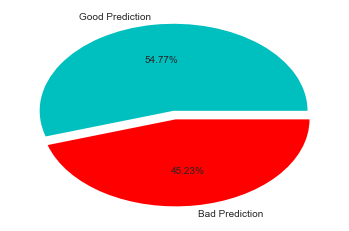

In [53]:
print('The model gave good predictions for the over/under in {}% of the games'.format(np.round(np.sum(preds_df.good_pred)/(len(preds_df))*100,2)))
print('\nNote: A prediction is classified as good when our model guides the bettor to a win or push')

plt.pie(x=[54.77,(100-54.77)],colors=['c','r'],labels=['Good Prediction', 'Bad Prediction'], explode=(0.05, 0.05),autopct='%1.2f%%');

In [21]:
pred_o_and_o=len(preds_df[(preds_df.over_under_pred>preds_df.over_under_line) & (preds_df.over_under_result==1)])/len(preds_df.over_under_result==1)
pred_u_and_o=len(preds_df[(preds_df.over_under_pred<preds_df.over_under_line) & (preds_df.over_under_result==1)])/len(preds_df.over_under_result==1)
pred_p_and_o=len(preds_df[(preds_df.over_under_pred==preds_df.over_under_line) & (preds_df.over_under_result==1)])/len(preds_df.over_under_result==1)


In [22]:
pred_u_and_u=len(preds_df[(preds_df.over_under_pred<preds_df.over_under_line) & (preds_df.over_under_result==0)])/len(preds_df.over_under_result==0)
pred_o_and_u=len(preds_df[(preds_df.over_under_pred>preds_df.over_under_line) & (preds_df.over_under_result==0)])/len(preds_df.over_under_result==0)
pred_p_and_u=len(preds_df[(preds_df.over_under_pred==preds_df.over_under_line) & (preds_df.over_under_result==0)])/len(preds_df.over_under_result==0)

In [23]:
pred_o_and_p=len(preds_df[(preds_df.over_under_pred>preds_df.over_under_line) & (preds_df.over_under_result==2)])/len(preds_df.over_under_result==2)
pred_u_and_p=len(preds_df[(preds_df.over_under_pred<preds_df.over_under_line) & (preds_df.over_under_result==2)])/len(preds_df.over_under_result==2)
pred_p_and_p=len(preds_df[(preds_df.over_under_pred==preds_df.over_under_line) & (preds_df.over_under_result==2)])/len(preds_df.over_under_result==2)

# Predicting O/U for all weeks 5-16 games since 1979

In [25]:
all_df = df[(df.schedule_week > 4) & (df.schedule_week < 17)]

In [ ]:
all_preds = past_predictions(all_df)
#all_preds

In [ ]:
all_games_df = all_df.drop(columns=['weather_detail', 'weather_temperature', 'weather_wind_mph',
       'weather_humidity', 'score_difference', 'home_id', 'away_id',
       'home_favorite', 'favorite_covered', 'winning_team', 'losing_team',
       'home_wins', 'home_losses', 'home_ties', 'away_wins', 'away_losses',
       'away_ties', 'home_points_for', 'home_points_against',
       'away_points_for', 'away_points_against', 'h_games', 'a_games',
       'home_win_pct', 'away_win_pct', 'win_pct_diff', 'h_ppg', 'h_papg',
       'a_ppg', 'a_papg', 'home_pt_diff_pg', 'away_pt_diff_pg', 'pt_diff_pg',
       'home_exp_win_pct', 'away_exp_win_pct', 'home_win_pct_last_4',
       'away_win_pct_last_4', 'exp_win_difference', 'total_ppg',
       'total_points_against', 'last_four_difference', 'dome','team_favorite_id','spread_favorite'])
all_games_df['over_under_pred'] = all_preds
all_games_df['pred-actual'] = all_games_df.over_under_pred- all_games_df.over_under_line

all_games_df['good_pred']= np.where((all_games_df.over_under_pred>all_games_df.over_under_line) & 
                                (all_games_df.point_total>all_games_df.over_under_line),1,0)
all_games_df['good_pred']= np.where((all_games_df.over_under_pred<all_games_df.over_under_line) & 
                                (all_games_df.point_total<all_games_df.over_under_line),1,all_games_df.good_pred)

all_games_df['good_pred']= np.where((all_games_df.over_under_pred==all_games_df.over_under_line),1,all_games_df.good_pred)
all_games_df['good_pred']= np.where((all_games_df.point_total==all_games_df.over_under_line),1,all_games_df.good_pred)

all_games_df['new_ou_result']=np.where(all_games_df.over_under_pred<all_games_df.point_total,1,0)
all_games_df['new_ou_result']=np.where(all_games_df.over_under_pred==all_games_df.point_total,2,all_games_df.new_ou_result)
#all_games_df[all_games_df.over_under_result==2]

In [44]:
print('The model gave good predictions for the over/under in {}% of the games'.format(np.round(np.sum(all_games_df.good_pred)/(len(all_games_df))*100,2)))
print('\nNote: A prediction is classified as good when our model guides the bettor to a win or push')

gp = np.round(np.sum(all_games_df.good_pred)/(len(all_games_df))*100,2)
plt.pie(x=[gp,(100-gp)],colors=['c','r'],labels=['Good Prediction', 'Bad Prediction'], explode=(0.05, 0.05),autopct='%1.2f%%');

NameError: name 'all_games_df' is not defined

In [ ]:
line=47.5
pred_o_given_o = len(preds_df[(preds_df.over_under_result==1) & (preds_df.over_under_line==line) & (preds_df.over_under_pred>preds_df.over_under_line)])/len(preds_df[(preds_df.over_under_result==1) & (preds_df.over_under_line==line)])
pred_p_given_o = len(preds_df[(preds_df.over_under_result==1) & (preds_df.over_under_line==line) & (preds_df.over_under_pred==preds_df.over_under_line)])/len(preds_df[(preds_df.over_under_result==1) & (preds_df.over_under_line==line)])
pred_u_given_o = len(preds_df[(preds_df.over_under_result==1) & (preds_df.over_under_line==line) & (preds_df.over_under_pred<preds_df.over_under_line)])/len(preds_df[(preds_df.over_under_result==1) & (preds_df.over_under_line==line)])

pred_o_given_p = len(preds_df[(preds_df.over_under_result==2) & (preds_df.over_under_line==line) & (preds_df.over_under_pred>preds_df.over_under_line)])/(len(preds_df[(preds_df.over_under_result==2) & (preds_df.over_under_line==line)])+1)
pred_p_given_p = len(preds_df[(preds_df.over_under_result==2) & (preds_df.over_under_line==line) & (preds_df.over_under_pred==preds_df.over_under_line)])/(len(preds_df[(preds_df.over_under_result==2) & (preds_df.over_under_line==line)])+1)
pred_u_given_p = len(preds_df[(preds_df.over_under_result==2) & (preds_df.over_under_line==line) & (preds_df.over_under_pred<preds_df.over_under_line)])/(len(preds_df[(preds_df.over_under_result==2) & (preds_df.over_under_line==line)])+1)

pred_o_given_u = len(preds_df[(preds_df.over_under_result==0) & (preds_df.over_under_line==line) & (preds_df.over_under_pred>preds_df.over_under_line)])/len(preds_df[(preds_df.over_under_result==0) & (preds_df.over_under_line==line)])
pred_p_given_u = len(preds_df[(preds_df.over_under_result==0) & (preds_df.over_under_line==line) & (preds_df.over_under_pred==preds_df.over_under_line)])/len(preds_df[(preds_df.over_under_result==0) & (preds_df.over_under_line==line)])
pred_u_given_u = len(preds_df[(preds_df.over_under_result==0) & (preds_df.over_under_line==line) & (preds_df.over_under_pred<preds_df.over_under_line)])/len(preds_df[(preds_df.over_under_result==0) & (preds_df.over_under_line==line)])

cond_probs = [pred_o_given_o,pred_p_given_o,pred_u_given_o, pred_o_given_p,pred_p_given_p,pred_u_given_p,
              pred_o_given_u,pred_p_given_u,pred_u_given_u]

In [ ]:
pred_o_given_o = len(preds_df[(preds_df.over_under_result==1) & (preds_df.over_under_line==line) & (preds_df.over_under_pred>preds_df.over_under_line)])/len(preds_df[(preds_df.over_under_result==1) & (preds_df.over_under_line==line)])
pred_p_given_o = len(preds_df[(preds_df.over_under_result==1) & (preds_df.over_under_line==line) & (preds_df.over_under_pred==preds_df.over_under_line)])/len(preds_df[(preds_df.over_under_result==1) & (preds_df.over_under_line==line)])
pred_u_given_o = len(preds_df[(preds_df.over_under_result==1) & (preds_df.over_under_line==line) & (preds_df.over_under_pred<preds_df.over_under_line)])/len(preds_df[(preds_df.over_under_result==1) & (preds_df.over_under_line==line)])


#pred_o_given_o + pred_p_given_o +pred_u_given_o



In [ ]:
# Pivot table % Covered Given line